## Download and process an arbitrary file from Common Crawl, extract individual items, perform basic statistical analysis (distribution of hosts, words, etc.) and visualization (optional)

In [6]:
from glob import glob
from gzip import GzipFile
from subprocess import call
from time import sleep
import requests, logging, chardet, re, sys, pdb, pickle
from bs4 import BeautifulSoup
from warcio.archiveiterator import ArchiveIterator
from progressbar import ProgressBar, UnknownLength
from langid import classify as langdetect
from readability.readability import Document, Unparseable
from collections import Counter
import pandas as pd

logging.basicConfig()
bar = ProgressBar(max_value=UnknownLength)

### Find arbitrary filename in downloaded file listing all CC files for specified period. Next download it to current dir

In [2]:
warclist = GzipFile(glob('warc*')[0])
for i, l in enumerate(warclist):
    if i % 1993 == 723:
        cc_file = f's3://commoncrawl/{l.decode().strip()}'
        break
        
call(['aws', 's3', 'cp', cc_file, '', '--no-sign-request'])
call(['rm', warclist.name])

### Process downloaded warc file

In [3]:
ccarc = glob('CC*.warc*')[0]
words = Counter()
langs = Counter()
sys.setrecursionlimit(10000)
print(ccarc)

CC-MAIN-20150728002301-00037-ip-10-236-191-2.ec2.internal.warc.gz


In [17]:
i = 0
with GzipFile(ccarc) as stream:
    for record in ArchiveIterator(stream):
        if record.rec_type != 'response':
            continue
        
        html = record.raw_stream.read()
        detected = chardet.detect(html)
        
        html = html.decode(detected['encoding'], errors='replace') \
               if detected['encoding'] \
               else html.decode(errors='replace')

        soup0 = BeautifulSoup(html, 'lxml').body
        if not soup0:
            continue
        # Often readability can't make sense of html, so let's help it a bit
        [s.extract() for s in soup0.select('*')
                     if s.name in ['script', 'nav', 'footer']
                        or len(s.text.strip()) < 3]

        if len(soup0.text.strip()) < 10:
            continue
        try:
            doc = Document(str(soup0)).summary()
            soup = BeautifulSoup(doc, 'lxml')
            if len(soup.text.strip())< 10:
                soup = soup0
        except (Unparseable, RecursionError):
            soup = soup0
            pass
        text = re.sub('\s+|(\xa0)+|\d+', ' ', soup.get_text(' ')).strip()
        try:
            langs.update([langdetect(text)[0]])
        except Exception as e:
            pdb.set_trace()
        words.update(re.findall('\w+', text))  # primitive tokenisation for speed
        i += 1
        bar.update(i)

\ 38440 Elapsed Time: 5:33:51                                                  /home/nr/prjctr/nlp_env/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "http://www.publicradio.org/tools/media/player/news/features/2007/06/22_extra_romanticmoment.smil

" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/ 53727 Elapsed Time: 8:24:35                                                  

In [20]:
import matplotlib.pyplot as plt

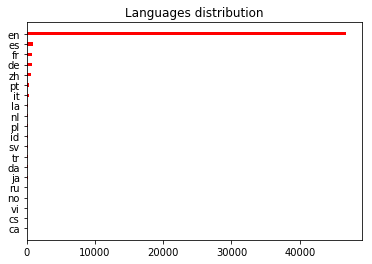

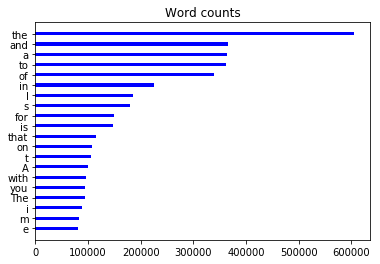

In [53]:
lang_labs = [k for k, v in langs.most_common(20)]
lang_values = [langs[k] for k in lang_labs]

word_labs = [k for k, v in words.most_common(20)]
word_values = [words[k] for k in word_labs]

plt.figure(1)
plt.barh(lang_labs, lang_values, 0.3, color="red")
ax = plt.gca()
ax.invert_yaxis()
ax.set_title('Languages distribution')

plt.figure(2)
plt.barh(word_labs, word_values, 0.3, color="blue")
ax = plt.gca()
ax.invert_yaxis()
ax.set_title('Word counts')

plt.show()

Stop-words are the most frequent so simple word count doesn't work. <br/>Language distribution looks close to reality, however prevalence of English can be explained also by bias in langid algorythm.